In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabpfn import TabPFNClassifier
import time
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import torch
import torch.nn as nn
import os
import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_VISIBLE_DEVICES'] = '3,4'

plt.style.use("default")

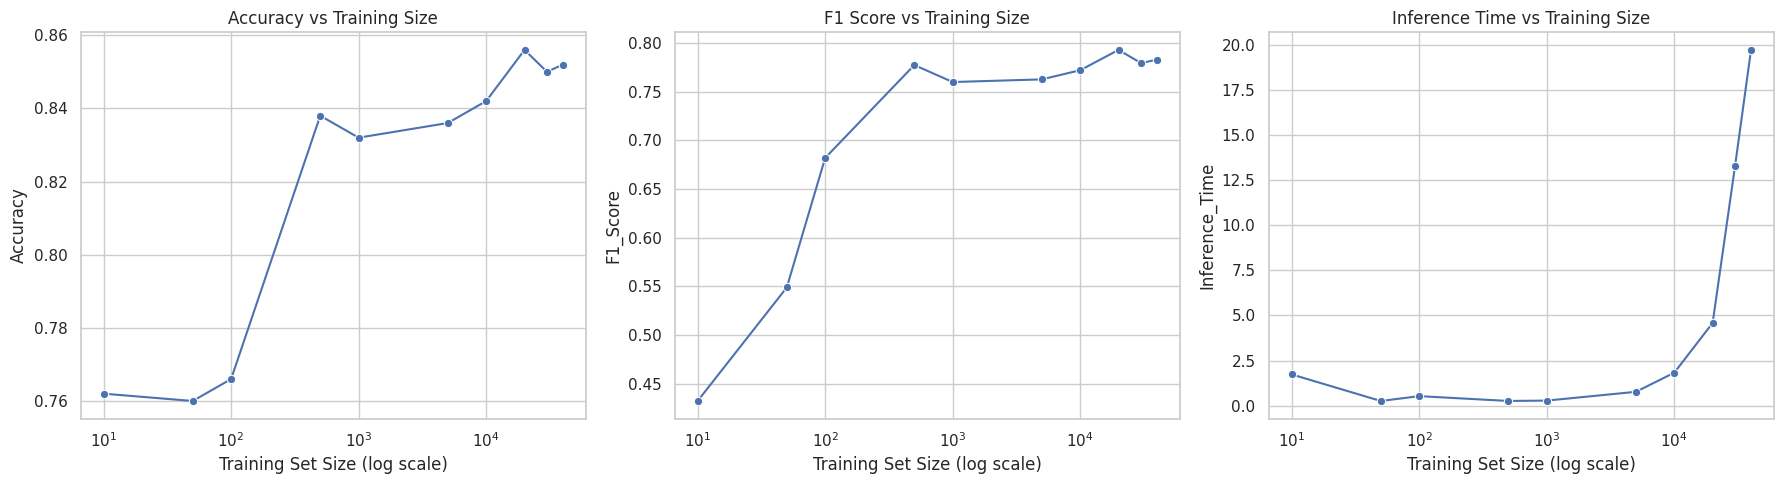

In [5]:
# Load data 
data_path = "adult.csv"
df = pd.read_csv(data_path)

# Encode categorical features
X = df.drop(columns=["class"])
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
df_encoded = X.copy()
df_encoded["class"] = df["class"]

# Split Train/Test
df_train_full = df_encoded.iloc[:-500]
df_test = df_encoded.iloc[-500:]

X_test = df_test.drop(columns=["class"]).values
y_test = df_test["class"]
y_test = y_test.map({"<=50K": 0, ">50K": 1}) if y_test.dtype == "object" else y_test
y_test = y_test.values

# Step 4: Train + Eval Loop 
training_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 20000, 30000, 40000]
results = []

for size in training_sizes:
    df_sampled = df_train_full.sample(n=size, random_state=42)
    X_train = df_sampled.drop(columns=["class"]).values
    y_train = df_sampled["class"]
    y_train = y_train.map({"<=50K": 0, ">50K": 1}) if y_train.dtype == "object" else y_train
    y_train = y_train.values

    clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu", ignore_pretraining_limits=True)
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    elapsed = time.time() - start_time

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Train_Size": size,
        "Accuracy": acc,
        "F1_Score": f1,
        "Inference_Time": elapsed
    })

# Step 5: Save results 
results_df = pd.DataFrame(results)
results_df.to_csv("tabpfn_scaling_results.csv", index=False)

# Step 6: Visualization 
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(data=results_df, x="Train_Size", y="Accuracy", marker="o", ax=axs[0])
axs[0].set_title("Accuracy vs Training Size")

sns.lineplot(data=results_df, x="Train_Size", y="F1_Score", marker="o", ax=axs[1])
axs[1].set_title("F1 Score vs Training Size")

sns.lineplot(data=results_df, x="Train_Size", y="Inference_Time", marker="o", ax=axs[2])
axs[2].set_title("Inference Time vs Training Size")

for ax in axs:
    ax.set_xscale("log")
    ax.set_xlabel("Training Set Size (log scale)")

plt.tight_layout()
plt.savefig("tabpfn_scaling_plot.png")
plt.show()

In [1]:
from sklearn.datasets import load_breast_cancer
from tabpfn_extensions import TabPFNClassifier, interpretability
# Load data
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize model
# clf = TabPFNClassifier(n_estimators=3)
clf = TabPFNClassifier(n_estimators=3, device="cuda")  # Use GPU for faster training

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf,
    X=X,
    y=y,
    n_features_to_select=5,  # How many features to select
    feature_names=feature_names,
)

# Print selected features
selected_features = [
    feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")


KeyboardInterrupt: 

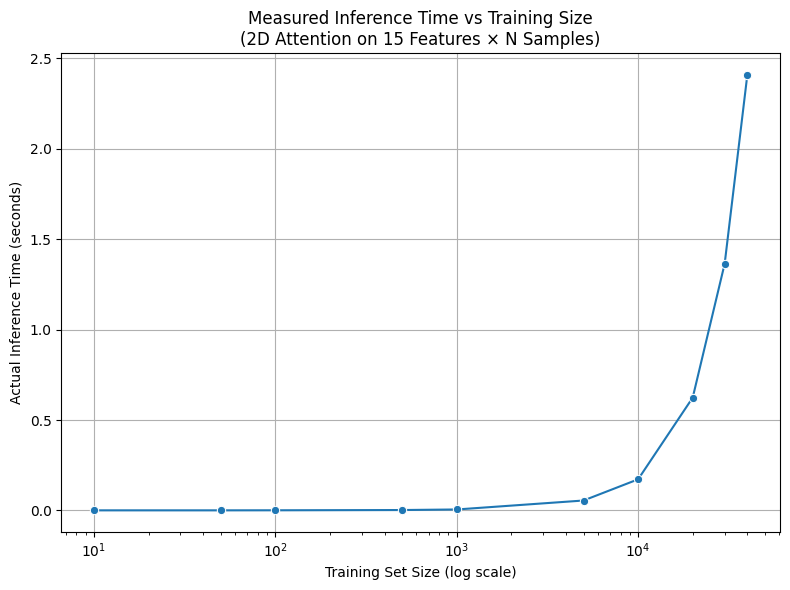

In [3]:
torch.manual_seed(0)

# 参数配置
feature_count = 15
sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000, 20000, 30000, 40000]
d_model = 64  # 每个 token 的 embedding 维度
nhead = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

# 定义 2D attention 模型（列 attention + 行 attention）
class TwoDAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        self.row_attn = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.col_attn = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)

    def forward(self, x):
        # x: [n_samples, feature_count, d_model]
        x_col = x.permute(1, 0, 2)               # [feature_count, n_samples, d_model]
        x_col = self.col_attn(x_col)
        x_col = x_col.permute(1, 0, 2)           # 回到 [n_samples, feature_count, d_model]

        x_row = self.row_attn(x_col)
        return x_row

# 初始化模型
model = TwoDAttention(d_model=d_model, nhead=nhead).to(device)
model.eval()

# 记录推理时间
inference_times = []

for n_samples in sample_sizes:
    x = torch.randn(n_samples, feature_count, d_model).to(device)

    # Warm-up
    with torch.no_grad():
        _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()

    # 正式计时
    start_time = time.time()
    with torch.no_grad():
        _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()

    elapsed = time.time() - start_time
    inference_times.append(elapsed)

# 可视化
plt.figure(figsize=(8, 6))
sns.lineplot(x=sample_sizes, y=inference_times, marker='o')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Training Set Size (log scale)")
plt.ylabel("Actual Inference Time (seconds)")
plt.title("Measured Inference Time vs Training Size\n(2D Attention on 15 Features × N Samples)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Bio response

Dataset shape: (3751, 1777)


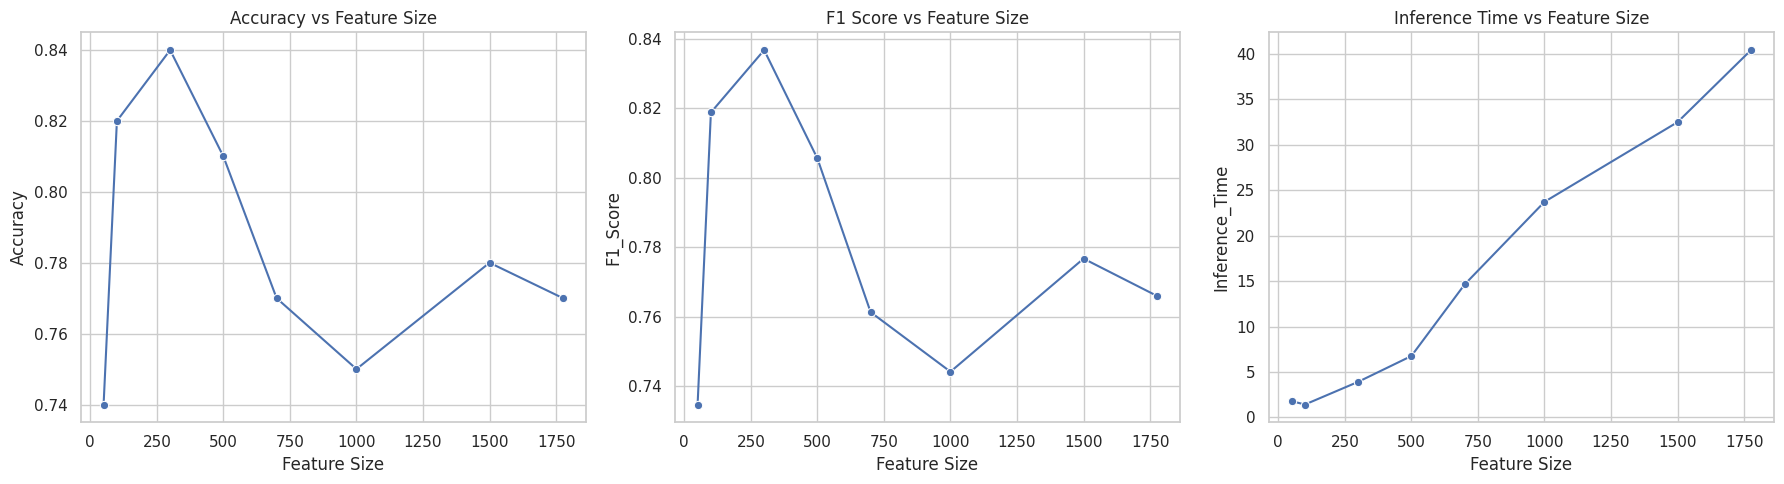

In [7]:
data_path = "/home/sunyvxuan/projects/TabPFN/data_OpenML_CC18/dataset_4134.csv"
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")

# Encode features (assuming numerical)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train_full = X[:-1000]
y_train_full = y[:-1000]
X_test = X[-100:]
y_test = y[-100:]

feature_sizes = [50, 100, 300, 500, 700, 1000, 1500, X.shape[1]]
results = []
csv_path = "tabpfn_feature_scaling_results.csv"

# 写入CSV文件头
pd.DataFrame(columns=["Feature_Size", "Accuracy", "F1_Score", "Inference_Time"]).to_csv(csv_path, index=False)

for size in feature_sizes:
    np.random.seed(42)
    feature_idx = np.random.choice(X.shape[1], size=min(size, X.shape[1]), replace=False)

    X_train = X_train_full[:, feature_idx]
    X_eval = X_test[:, feature_idx]

    clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu", ignore_pretraining_limits=True)
    
    start_time = time.time()
    clf.fit(X_train, y_train_full)
    y_pred = clf.predict(X_eval)
    elapsed = time.time() - start_time

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    result_row = {
        "Feature_Size": len(feature_idx),
        "Accuracy": acc,
        "F1_Score": f1,
        "Inference_Time": elapsed
    }
    results.append(result_row)

    # 实时追加写入CSV
    pd.DataFrame([result_row]).to_csv(csv_path, mode="a", header=False, index=False)

# 可选：最后再读一遍所有结果用于可视化
results_df = pd.read_csv(csv_path)

# Visualization
sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(data=results_df, x="Feature_Size", y="Accuracy", marker="o", ax=axs[0])
axs[0].set_title("Accuracy vs Feature Size")

sns.lineplot(data=results_df, x="Feature_Size", y="F1_Score", marker="o", ax=axs[1])
axs[1].set_title("F1 Score vs Feature Size")

sns.lineplot(data=results_df, x="Feature_Size", y="Inference_Time", marker="o", ax=axs[2])
axs[2].set_title("Inference Time vs Feature Size")

for ax in axs:
    ax.set_xlabel("Feature Size")

plt.tight_layout()
plt.show()

In [ ]:
def matrix_multiply(A, B):
    n = A.shape[0]
    ans = np.zeros((n, n), dtype=A.dtype)
    for i in range(n):
        for j in range(n):
            ans[i, j] = np.sum(A[i, :] * B[:, j])
    return ans
